In [ ]:
# 1. Imports
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# 2. Load dataset
data_path = '/Users/admin/Library/CloudStorage/OneDrive-GettysburgCollege/DS325/Baza customer Telecom v2.csv' 
df = pd.read_csv(data_path)

# 3. Quick inspection
print("Dataset shape:", df.shape)
display(df.head())
df.info()
df.describe() 


In [ ]:
# 4. Missing Data Inspection & Imputation

# Inspect missing values
missing = df.isnull().sum()
print("Missing values before imputation:")
display(missing)

# Impute subscriber count nulls with 0
df['Not_Active_subscribers'] = df['Not_Active_subscribers'].fillna(0)
df['Suspended_subscribers'] = df['Suspended_subscribers'].fillna(0)

# Handle ARPU nulls by recalculating where possible
computed_arpu = df['TotalRevenue'] / df['Active_subscribers'].replace(0, pd.NA)
df['ARPU'] = df['ARPU'].fillna(computed_arpu).fillna(0)

# Convert CHURN to numeric 0/1
df['CHURN'] = df['CHURN'].map({'No': 0, 'Yes': 1})

# Verify changes
print("\nMissing values after imputation:")
display(df.isnull().sum())

print("\nData types and sample values:")
display(df[['Not_Active_subscribers','Suspended_subscribers','ARPU','CHURN']].head())



In [ ]:
# 4.b Clean column names (strip whitespace)
df.columns = df.columns.str.strip()

# 5. Sanity Checks: Subscriber and Revenue Consistency

# 5.1 Subscriber totals check
df['subs_sum'] = (
    df['Active_subscribers'] +
    df['Not_Active_subscribers'] +
    df['Suspended_subscribers']
)
subs_mismatch = df['subs_sum'] != df['Total_SUBs']
subs_mismatch_count = subs_mismatch.sum()

# 5.2 Revenue components check
# Round to cents for comparison
mobile_fix_sum = (df['AvgMobileRevenue'] + df['AvgFIXRevenue']).round(2)
total_rev = df['TotalRevenue'].round(2)
rev_mismatch = mobile_fix_sum != total_rev
rev_mismatch_count = rev_mismatch.sum()

# Display summary
print(f"Subscriber count mismatches: {subs_mismatch_count} of {len(df)}")
print(f"Revenue sum mismatches: {rev_mismatch_count} of {len(df)}")

# Show a few examples of each mismatch type
if subs_mismatch_count > 0:
    display(df.loc[subs_mismatch, 
                   ['PID', 'Active_subscribers', 'Not_Active_subscribers', 
                    'Suspended_subscribers', 'Total_SUBs', 'subs_sum']].head())

if rev_mismatch_count > 0:
    display(df.loc[rev_mismatch, 
                   ['PID', 'AvgMobileRevenue', 'AvgFIXRevenue', 
                    'TotalRevenue']].head())



In [ ]:
# 7. Finalizing Type Conversions & Preprocessor Definition

# Handle missing Billing_ZIP and create ZIP_region
df['Billing_ZIP'] = df['Billing_ZIP'].fillna(0).astype(int).astype(str)
df['ZIP_region'] = df['Billing_ZIP'].str[:2]

# Define feature lists
categorical_features = [
    'CRM_PID_Value_Segment', 
    'EffectiveSegment', 
    'KA_name', 
    'ZIP_region'
]
numeric_features = [
    'Active_subscribers', 
    'Not_Active_subscribers', 
    'Suspended_subscribers', 
    'Total_SUBs',
    'AvgMobileRevenue', 
    'AvgFIXRevenue', 
    'TotalRevenue', 
    'ARPU'
]

# Convert to categorical dtype
df[categorical_features] = df[categorical_features].astype('category')

# Build preprocessing pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])
from sklearn.preprocessing import OneHotEncoder

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])


# Preview: print the transformer names and feature counts
print("Transformer steps:")
print(preprocessor)



In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline

# 8. Prepare features and target
feature_cols = numeric_features + categorical_features
X = df[feature_cols]
y = df['CHURN']

RANDOM_STATE = 42 

# 9. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# 10. Logistic Regression Pipeline
clf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=RANDOM_STATE))
])

# 11. Fit the model
clf_pipeline.fit(X_train, y_train)

# 12. Predictions and Probabilities
y_pred = clf_pipeline.predict(X_test)
y_proba = clf_pipeline.predict_proba(X_test)[:, 1]

# 13. Evaluation Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.3f}")

# 14. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


Classification Report:
              precision    recall  f1-score   support

    No Churn       0.93      1.00      0.97      1581
       Churn       0.00      0.00      0.00       110

    accuracy                           0.93      1691
   macro avg       0.47      0.50      0.48      1691
weighted avg       0.87      0.93      0.90      1691

ROC AUC Score: 0.580

Confusion Matrix:
[[1581    0]
 [ 110    0]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [6]:
numeric_features     = [
    'Active_subscribers','Not_Active_subscribers','Suspended_subscribers',
    'Total_SUBs','AvgMobileRevenue','AvgFIXRevenue','TotalRevenue','ARPU'
]
categorical_features = [
    'CRM_PID_Value_Segment','EffectiveSegment','KA_name','ZIP_region'
]
df[categorical_features] = df[categorical_features].astype('category')

# Build preprocessor
numeric_pipeline = Pipeline([('scaler', StandardScaler())])
categorical_pipeline = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Split
X = df[numeric_features + categorical_features]
y = df['CHURN']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Default Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100, 
        random_state=RANDOM_STATE, 
        class_weight='balanced'
    ))
])
rf_pipeline.fit(X_train, y_train)

# Evaluate
y_pred = rf_pipeline.predict(X_test)
y_proba = rf_pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, target_names=['No Churn','Churn'], zero_division=0))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(confusion_matrix(y_test, y_pred))


Classification Report (Balanced Logistic Regression):
              precision    recall  f1-score   support

    No Churn       0.95      0.60      0.73      1581
       Churn       0.08      0.53      0.14       110

    accuracy                           0.59      1691
   macro avg       0.52      0.56      0.44      1691
weighted avg       0.89      0.59      0.70      1691

ROC AUC Score: 0.572

Confusion Matrix:
[[947 634]
 [ 52  58]]


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Random Forest pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=RANDOM_STATE
    ))
])

# Fit
rf_pipeline.fit(X_train, y_train)

# Predict & evaluate
y_pred = rf_pipeline.predict(X_test)
y_proba = rf_pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, target_names=['No Churn','Churn'], zero_division=0))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

    No Churn       0.93      1.00      0.96      1581
       Churn       0.00      0.00      0.00       110

    accuracy                           0.93      1691
   macro avg       0.47      0.50      0.48      1691
weighted avg       0.87      0.93      0.90      1691

ROC AUC: 0.575
[[1575    6]
 [ 110    0]]


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# 1. Define hyperparameter grid
param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2']
}

# 2. Randomized search around your existing pipeline
rs_rf = RandomizedSearchCV(
    estimator=Pipeline([
        ('prep', preprocessor),
        ('classifier', RandomForestClassifier(
            class_weight='balanced',
            random_state=RANDOM_STATE
        ))
    ]),
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

# 3. Fit
rs_rf.fit(X_train, y_train)

# 4. Best parameters & CV score
print("Best parameters:", rs_rf.best_params_)
print(f"Best CV ROC AUC: {rs_rf.best_score_:.3f}\n")

# 5. Test-set evaluation
best_rf = rs_rf.best_estimator_
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

print("=== Tuned Random Forest ===")
print(classification_report(y_test, y_pred, target_names=['No Churn','Churn'], zero_division=0))
print(f"Test ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 10}
Best CV ROC AUC: 0.582

=== Tuned Random Forest ===
              precision    recall  f1-score   support

    No Churn       0.94      0.86      0.90      1581
       Churn       0.10      0.21      0.13       110

    accuracy                           0.82      1691
   macro avg       0.52      0.54      0.52      1691
weighted avg       0.89      0.82      0.85      1691

Test ROC AUC: 0.567
Confusion Matrix:
 [[1363  218]
 [  87   23]]


In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# 1. Build pipeline
gb_pipeline = Pipeline([
    ('prep', preprocessor),
    ('clf', GradientBoostingClassifier(random_state=RANDOM_STATE))
])

# 2. Fit
gb_pipeline.fit(X_train, y_train)

# 3. Predict & Evaluate
y_pred_gb  = gb_pipeline.predict(X_test)
y_proba_gb = gb_pipeline.predict_proba(X_test)[:, 1]

print("=== Baseline Gradient Boosting ===")
print(classification_report(y_test, y_pred_gb, target_names=['No Churn','Churn'], zero_division=0))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_gb):.3f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))


=== Baseline Gradient Boosting ===
              precision    recall  f1-score   support

    No Churn       0.93      1.00      0.97      1581
       Churn       0.00      0.00      0.00       110

    accuracy                           0.93      1691
   macro avg       0.47      0.50      0.48      1691
weighted avg       0.87      0.93      0.90      1691

ROC AUC: 0.579
Confusion Matrix:
 [[1581    0]
 [ 110    0]]


In [18]:
# 1. Get feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# 2. Extract importances from the best RF
best_rf = rs_rf.best_estimator_.named_steps['classifier']
importances = best_rf.feature_importances_

# 3. Build a DataFrame and sort
import pandas as pd
feat_imp_df = (
    pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

# 4. View the top 10
print(feat_imp_df.head(10))


                       feature  importance
0            num__TotalRevenue    0.140315
1        num__AvgMobileRevenue    0.139492
2                    num__ARPU    0.120612
3              num__Total_SUBs    0.092981
4      num__Active_subscribers    0.084986
5  num__Not_Active_subscribers    0.061111
6           cat__ZIP_region_61    0.016072
7           cat__ZIP_region_60    0.014917
8   cat__EffectiveSegment_SOHO    0.014644
9    cat__EffectiveSegment_VSE    0.014551


In [19]:
lr = clf_balanced.named_steps['classifier']
coefs = lr.coef_[0]
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs
}).sort_values('coefficient', key=abs, ascending=False).reset_index(drop=True)

print(coef_df.head(10))


                           feature  coefficient
0               cat__ZIP_region_88     1.821485
1  cat__CRM_PID_Value_Segment_Lead    -1.416467
2               cat__ZIP_region_89    -1.412489
3               cat__ZIP_region_82     1.394888
4               cat__ZIP_region_69     1.363668
5               cat__ZIP_region_16     1.223595
6               cat__ZIP_region_80     1.171198
7               cat__ZIP_region_58     1.153002
8               cat__ZIP_region_86     1.087824
9               cat__ZIP_region_49    -1.053516


In [23]:

from sklearn.inspection import permutation_importance
from scipy.sparse import issparse
import pandas as pd

# 1. Preprocess your test set
X_test_trans = preprocessor.transform(X_test)
if issparse(X_test_trans):
    X_test_trans = X_test_trans.toarray()

# 2. Compute permutation importances on AUC
perm = permutation_importance(
    best_rf, 
    X_test_trans, 
    y_test, 
    n_repeats=10, 
    random_state=RANDOM_STATE, 
    scoring='roc_auc'
)

# 3. Build a DataFrame of results
feature_names = preprocessor.get_feature_names_out()
perm_df = (
    pd.DataFrame({
        'feature': feature_names,
        'importance_mean': perm.importances_mean,
        'importance_std':  perm.importances_std
    })
    .sort_values('importance_mean', ascending=False)
    .head(10)
    .reset_index(drop=True)
)

# 4. Print the top 10 features
print(perm_df.to_string(index=False))


                            feature  importance_mean  importance_std
              num__AvgMobileRevenue         0.028604        0.017313
                  num__TotalRevenue         0.022974        0.010261
                 cat__ZIP_region_65         0.007149        0.004303
                    cat__KA_name_DI         0.006618        0.003877
                          num__ARPU         0.006402        0.006108
                 cat__ZIP_region_63         0.004181        0.002045
          cat__KA_name_Jenia Gogova         0.003864        0.003129
                 cat__ZIP_region_47         0.002807        0.000892
    cat__CRM_PID_Value_Segment_Gold         0.002636        0.004023
cat__CRM_PID_Value_Segment_Platinum         0.002555        0.001467


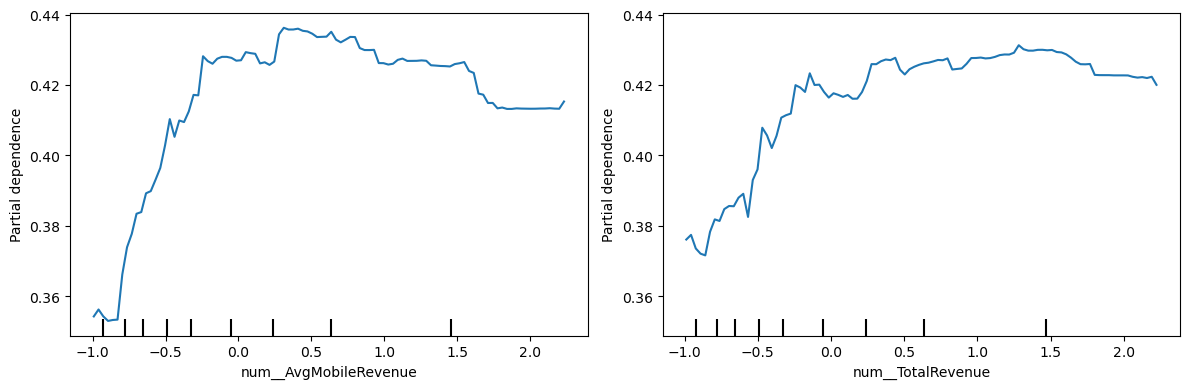

In [24]:
import matplotlib.pyplot as plt
from scipy.sparse import issparse
from sklearn.inspection import PartialDependenceDisplay

# 1. Re-transform your test set to dense array if needed
X_test_trans = preprocessor.transform(X_test)
if issparse(X_test_trans):
    X_test_trans = X_test_trans.toarray()

# 2. Select the top 2 drivers from your permutation importances
top_features = perm_df['feature'].tolist()[:2]

# 3. Plot partial dependence for those features
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
PartialDependenceDisplay.from_estimator(
    best_rf,
    X_test_trans,
    features=top_features,
    feature_names=preprocessor.get_feature_names_out(),
    ax=ax
)
plt.tight_layout()
plt.show()


/var/folders/06/kk3v10sj7931bhvb4m36h_j80000gn/T/ipykernel_35264/3977559055.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg_df = df.groupby('CRM_PID_Value_Segment')['CHURN'] \
/var/folders/06/kk3v10sj7931bhvb4m36h_j80000gn/T/ipykernel_35264/3977559055.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


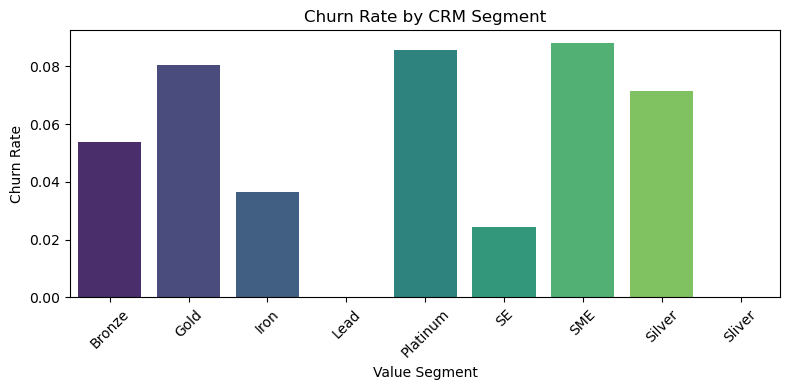

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assemble a DataFrame of segment vs churn rate
seg_df = df.groupby('CRM_PID_Value_Segment')['CHURN'] \
           .mean() \
           .sort_values(ascending=False) \
           .reset_index()

plt.figure(figsize=(8,4))
sns.barplot(
    data=seg_df,
    x='CRM_PID_Value_Segment',
    y='CHURN',
    palette='viridis'
)
plt.ylabel('Churn Rate')
plt.xlabel('Value Segment')
plt.title('Churn Rate by CRM Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/06/kk3v10sj7931bhvb4m36h_j80000gn/T/ipykernel_35264/2195116264.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data=df.groupby('EffectiveSegment')['CHURN']
/var/folders/06/kk3v10sj7931bhvb4m36h_j80000gn/T/ipykernel_35264/2195116264.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


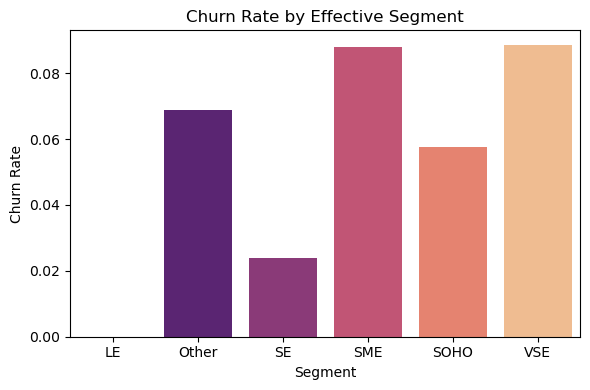

In [26]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=df.groupby('EffectiveSegment')['CHURN']
           .mean()
           .sort_values(ascending=False)
           .reset_index(),
    x='EffectiveSegment',
    y='CHURN',
    palette='magma'
)
plt.title('Churn Rate by Effective Segment')
plt.ylabel('Churn Rate')
plt.xlabel('Segment')
plt.tight_layout()
plt.show()


/var/folders/06/kk3v10sj7931bhvb4m36h_j80000gn/T/ipykernel_35264/136084214.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/06/kk3v10sj7931bhvb4m36h_j80000gn/T/ipykernel_35264/136084214.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set(
/var/folders/06/kk3v10sj7931bhvb4m36h_j80000gn/T/ipykernel_35264/136084214.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/06/kk3v10sj7931bhvb4m36h_j80000gn/T/ipykernel_35264/136084214.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[

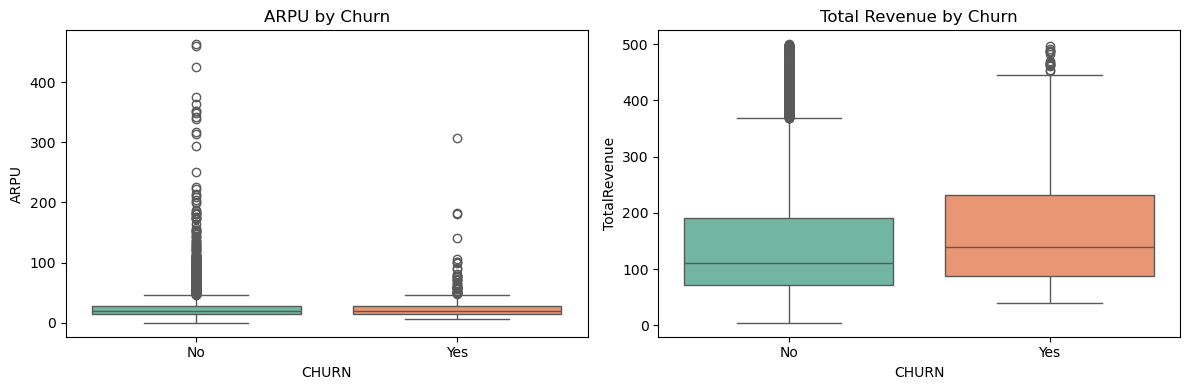

In [27]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.boxplot(
    data=df, x='CHURN', y='ARPU', 
    ax=axes[0], palette='Set2'
)
axes[0].set(
    xticklabels=['No','Yes'], 
    title='ARPU by Churn'
)

sns.boxplot(
    data=df, x='CHURN', y='TotalRevenue', 
    ax=axes[1], palette='Set2'
)
axes[1].set(
    xticklabels=['No','Yes'],
    title='Total Revenue by Churn'
)

plt.tight_layout()
plt.show()


/var/folders/06/kk3v10sj7931bhvb4m36h_j80000gn/T/ipykernel_35264/1738955153.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/06/kk3v10sj7931bhvb4m36h_j80000gn/T/ipykernel_35264/1738955153.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set(
/var/folders/06/kk3v10sj7931bhvb4m36h_j80000gn/T/ipykernel_35264/1738955153.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/06/kk3v10sj7931bhvb4m36h_j80000gn/T/ipykernel_35264/1738955153.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocat

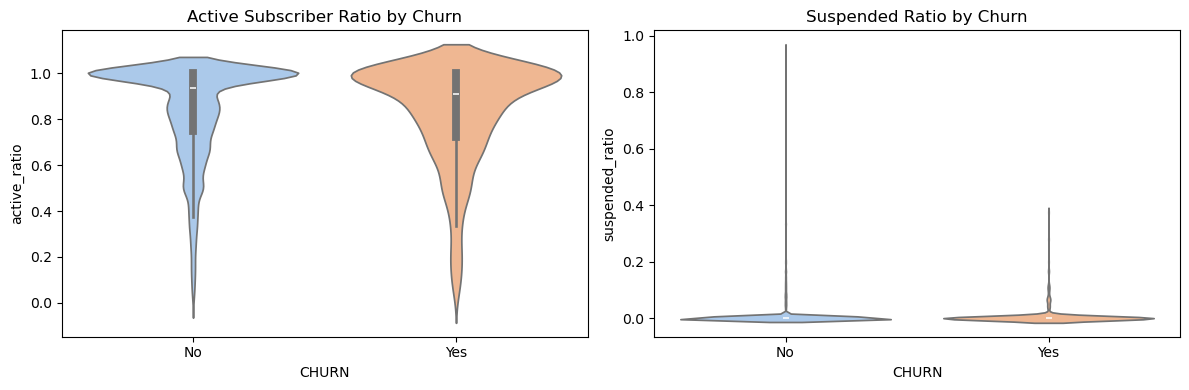

In [28]:
# Compute ratios
df['active_ratio']    = df['Active_subscribers']    / df['Total_SUBs']
df['suspended_ratio'] = df['Suspended_subscribers'] / df['Total_SUBs']

fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.violinplot(
    data=df, x='CHURN', y='active_ratio', 
    ax=axes[0], palette='pastel'
)
axes[0].set(
    xticklabels=['No','Yes'],
    title='Active Subscriber Ratio by Churn'
)

sns.violinplot(
    data=df, x='CHURN', y='suspended_ratio', 
    ax=axes[1], palette='pastel'
)
axes[1].set(
    xticklabels=['No','Yes'],
    title='Suspended Ratio by Churn'
)

plt.tight_layout()
plt.show()


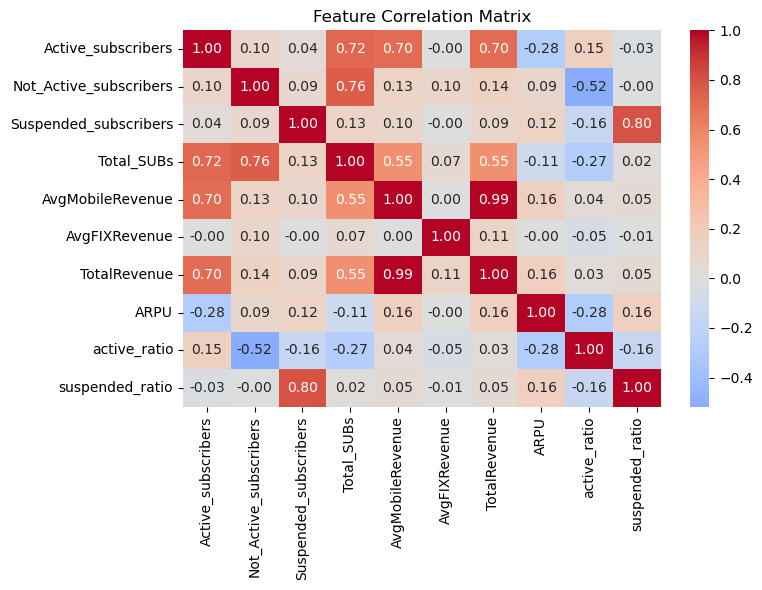

In [29]:
plt.figure(figsize=(8,6))
sns.heatmap(
    df[numeric_features + ['active_ratio','suspended_ratio']] \
      .corr(),
    annot=True, fmt='.2f', cmap='coolwarm', center=0
)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


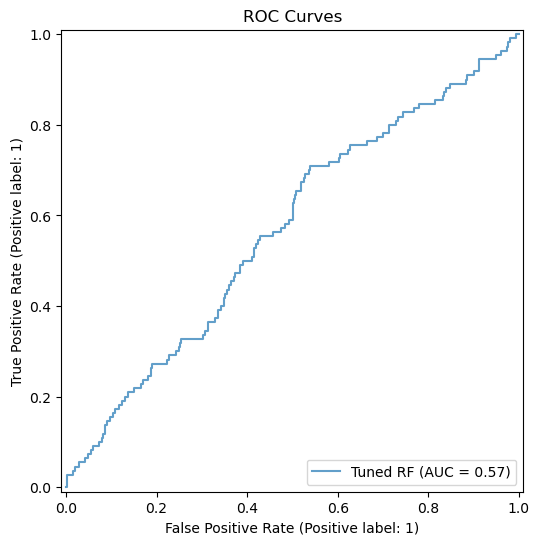

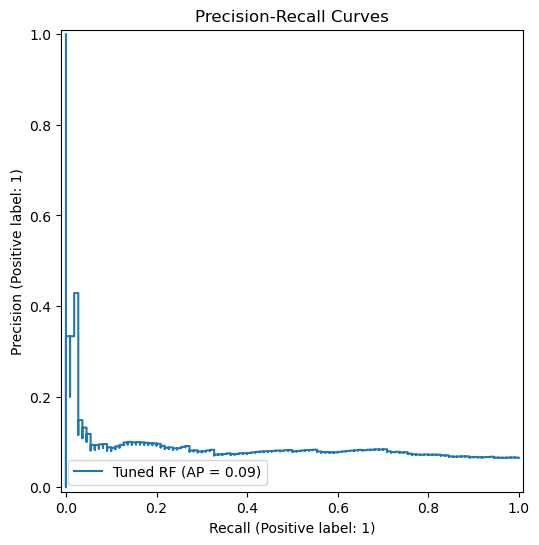

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

# Make sure best_pipeline is your Pipeline (preprocessor + classifier)
best_pipeline = rs_rf.best_estimator_

# ROC curve
fig, ax = plt.subplots(figsize=(6,6))
RocCurveDisplay.from_estimator(
    best_pipeline, 
    X_test, 
    y_test, 
    name='Tuned RF', 
    alpha=0.7, 
    ax=ax
)
# Add other models if you like:
# RocCurveDisplay.from_estimator(best_gb_pipeline, X_test, y_test, name='Tuned GB', ax=ax)

ax.set_title('ROC Curves')
plt.show()

# Precision-Recall curve
fig, ax = plt.subplots(figsize=(6,6))
PrecisionRecallDisplay.from_estimator(
    best_pipeline, 
    X_test, 
    y_test, 
    name='Tuned RF', 
    ax=ax
)
# PrecisionRecallDisplay.from_estimator(best_gb_pipeline, X_test, y_test, name='Tuned GB', ax=ax)
ax.set_title('Precision-Recall Curves')
plt.show()


/var/folders/06/kk3v10sj7931bhvb4m36h_j80000gn/T/ipykernel_35264/3005910821.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


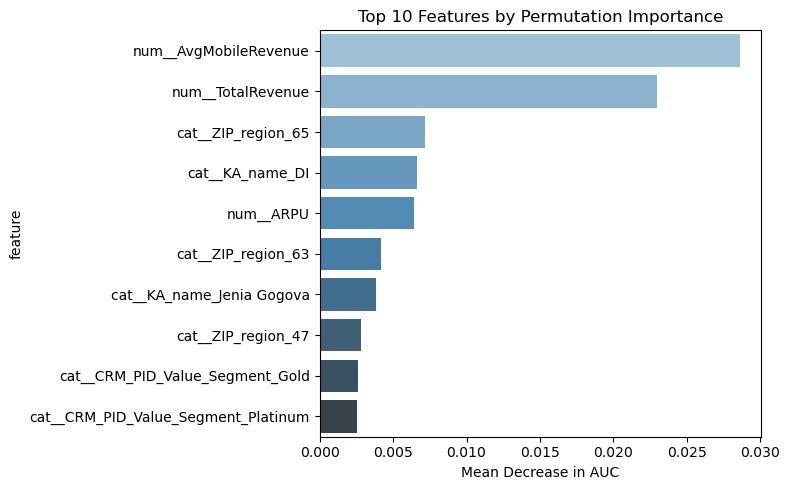

In [31]:
top10 = perm_df.head(10)
plt.figure(figsize=(8,5))
sns.barplot(
    data=top10, 
    x='importance_mean', 
    y='feature', 
    palette='Blues_d'
)
plt.xlabel('Mean Decrease in AUC')
plt.title('Top 10 Features by Permutation Importance')
plt.tight_layout()
plt.show()
